In [1]:
# This script is used to train random forest model.
# from matminer.featurizers.composition.composite import ElementProperty
from pymatgen.core.composition import Composition
import matminer.featurizers.composition as cf
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

ep = cf.ElementProperty.from_preset(preset_name="magpie", impute_nan=True)

/Users/siyuliu/anaconda3/envs/ec-test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json
from datasets import Dataset
training_set = Dataset.from_json("../../../reproduce/data/prompt_type_4/real_train_dataset_with_mpid.json")
validation_set = Dataset.from_json("../../../reproduce/data/prompt_type_4/real_val_dataset_with_mpid.json")
with open('../../../reproduce/data/prompt_type_4/ec_desc_test_dataset_with_mpid.json') as f:
    test_set = json.load(f)

Generating train split: 9498 examples [00:00, 161929.86 examples/s]
Generating train split: 500 examples [00:00, 68774.87 examples/s]


In [3]:
print(len(training_set))
print(len(validation_set))
print(len(test_set))

9498
500
522


In [4]:
import re

def extract_material_description(text):
    pattern = r"The material(.*?)with"
    match = re.search(pattern, text)
    if match:
        return match.group(1).strip()
    else:
        print(f"Pattern not found in text: {text}")
        return "No description found"

train_desc = [extract_material_description(d['input']) for d in training_set]
val_desc = [extract_material_description(d['input']) for d in validation_set]
test_desc = [extract_material_description(d['input']) for d in test_set]


In [5]:
training_compostion = [Composition(comp) for comp in train_desc]
val_compostion = [Composition(comp) for comp in val_desc]
test_compostion = [Composition(comp) for comp in test_desc]
training_features = ep.featurize_many(training_compostion)
validation_features = ep.featurize_many(val_compostion)
test_features = ep.featurize_many(test_compostion)

ElementProperty: 100%|██████████| 522/522 [00:16<00:00, 30.87it/s]


In [6]:
import numpy as np

# Find indices where any element in the feature list is NaN
def find_nan_indices(features_list):
    nan_indices = []
    for i, f in enumerate(features_list):
        if np.isnan(f).any():
            nan_indices.append(i)
    
    return nan_indices

print("Indices with NaN in training features:", find_nan_indices(training_features))
print("Indices with NaN in validation features:", find_nan_indices(validation_features))
print("Indices with NaN in test features:", find_nan_indices(test_features))

Indices with NaN in training features: []
Indices with NaN in validation features: []
Indices with NaN in test features: []


In [7]:
import numpy as np
training_elastic_tensor = [np.array(eval(tensor['output'])).flatten() for tensor in training_set]
val_elastic_tensor = [np.array(eval(tensor['output'])).flatten() for tensor in validation_set]
test_elastic_tensor = [np.array(eval(tensor['output'])).flatten() for tensor in test_set]

In [8]:
print(len(training_elastic_tensor))
print(len(val_elastic_tensor))
print(len(test_features))

9498
500
522


In [9]:
model = RandomForestRegressor(random_state=42)

In [10]:
model.fit(training_features, training_elastic_tensor)

RandomForestRegressor(random_state=42)

In [11]:
test_predictions = model.predict(test_features)

In [12]:
test_tensors = [np.array(tensor).reshape(6,6) for tensor in test_predictions]

In [13]:
test_elastic_tensor = [np.array(tensor).reshape(6,6) for tensor in test_elastic_tensor]

In [14]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
predict_mean = [np.mean(i) for i in test_tensors]
real_mean = [np.mean(i) for i in test_elastic_tensor]
print(len(predict_mean), len(real_mean))
mae_cij = mean_absolute_error(real_mean, predict_mean)
r2_cij = r2_score(real_mean, predict_mean)
print(mae_cij)
print(r2_cij)

522 522
3.3293445883209833
0.9238896692797384


In [15]:
## 根据弹性常数计算bulk modulus, shear modulus, young's modulus
from pymatgen.analysis.elasticity import ElasticTensor
import numpy as np

def calculate_properties(stiffness_matrix: list) -> (float, float, float):
    elastic_constant = np.asarray(stiffness_matrix)
    elastic_tensor = ElasticTensor.from_voigt(elastic_constant)
    bulk_modulus = round(elastic_tensor.k_voigt, 3)
    return bulk_modulus

In [16]:
real_k_voigt = [calculate_properties(tensor) for tensor in test_elastic_tensor]
test_k_voigt = [calculate_properties(tensor) for tensor in test_tensors]

In [17]:
print(len(real_k_voigt), len(test_k_voigt))

522 522


In [24]:
# export the predicted and real elastic tensor
np.save('rf_elastic_tensors_predicted_test_set.npy', test_tensors)
np.save('rf_elastic_tensors_real_test_set.npy', test_elastic_tensor)

In [18]:
# calculate mae loss
from sklearn.metrics import mean_absolute_error, r2_score
mae = mean_absolute_error(real_k_voigt, test_k_voigt)
r2 = r2_score(real_k_voigt, test_k_voigt)
print(mae)
print(r2)

10.580289272030651
0.9270037042439766


In [20]:
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import scienceplots
plt.style.use('ieee')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

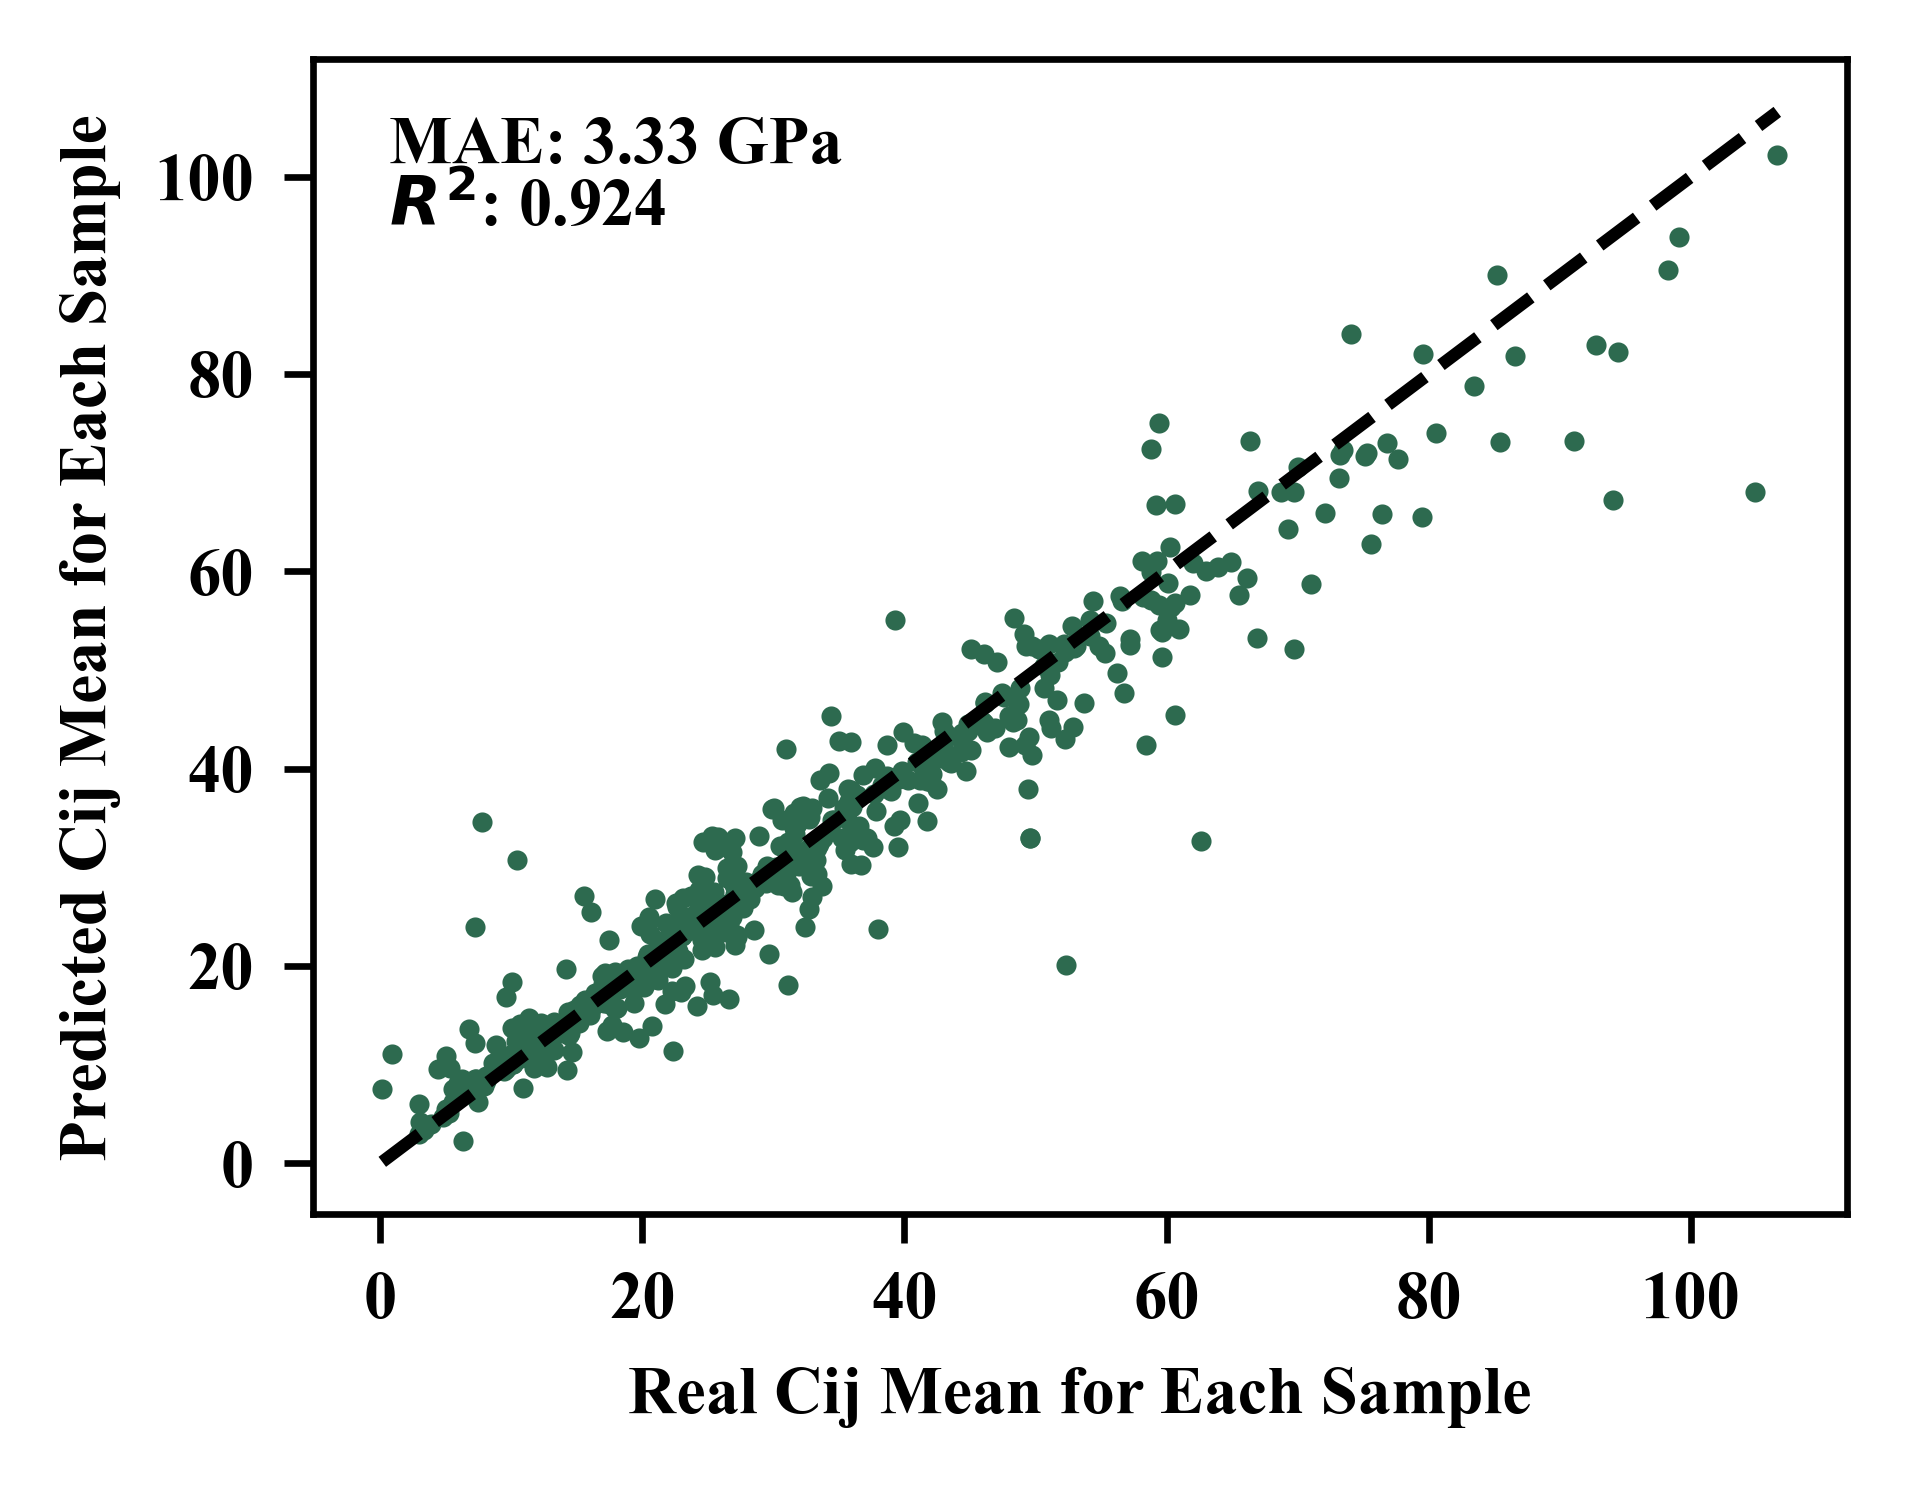

In [21]:
# rf
import matplotlib.pyplot as plt
plt.scatter(real_mean, predict_mean, color='#2d6a4f', s=2)  # Adjusted point size
plt.xlabel('Real Cij Mean for Each Sample')
plt.ylabel('Predicted Cij Mean for Each Sample')
plt.plot([min(real_mean), max(real_mean)], [min(real_mean), max(real_mean)], 'k--')  # y=x dashed line in black
plt.text(0.05, 0.95, 'MAE: 3.33 GPa', transform=plt.gca().transAxes, fontsize=8, verticalalignment='top')
plt.text(0.05, 0.90, r'$R^2$: 0.924', transform=plt.gca().transAxes, fontsize=8, verticalalignment='top')
plt.savefig("rf_scatter.pdf", dpi=600, bbox_inches='tight')
plt.show()

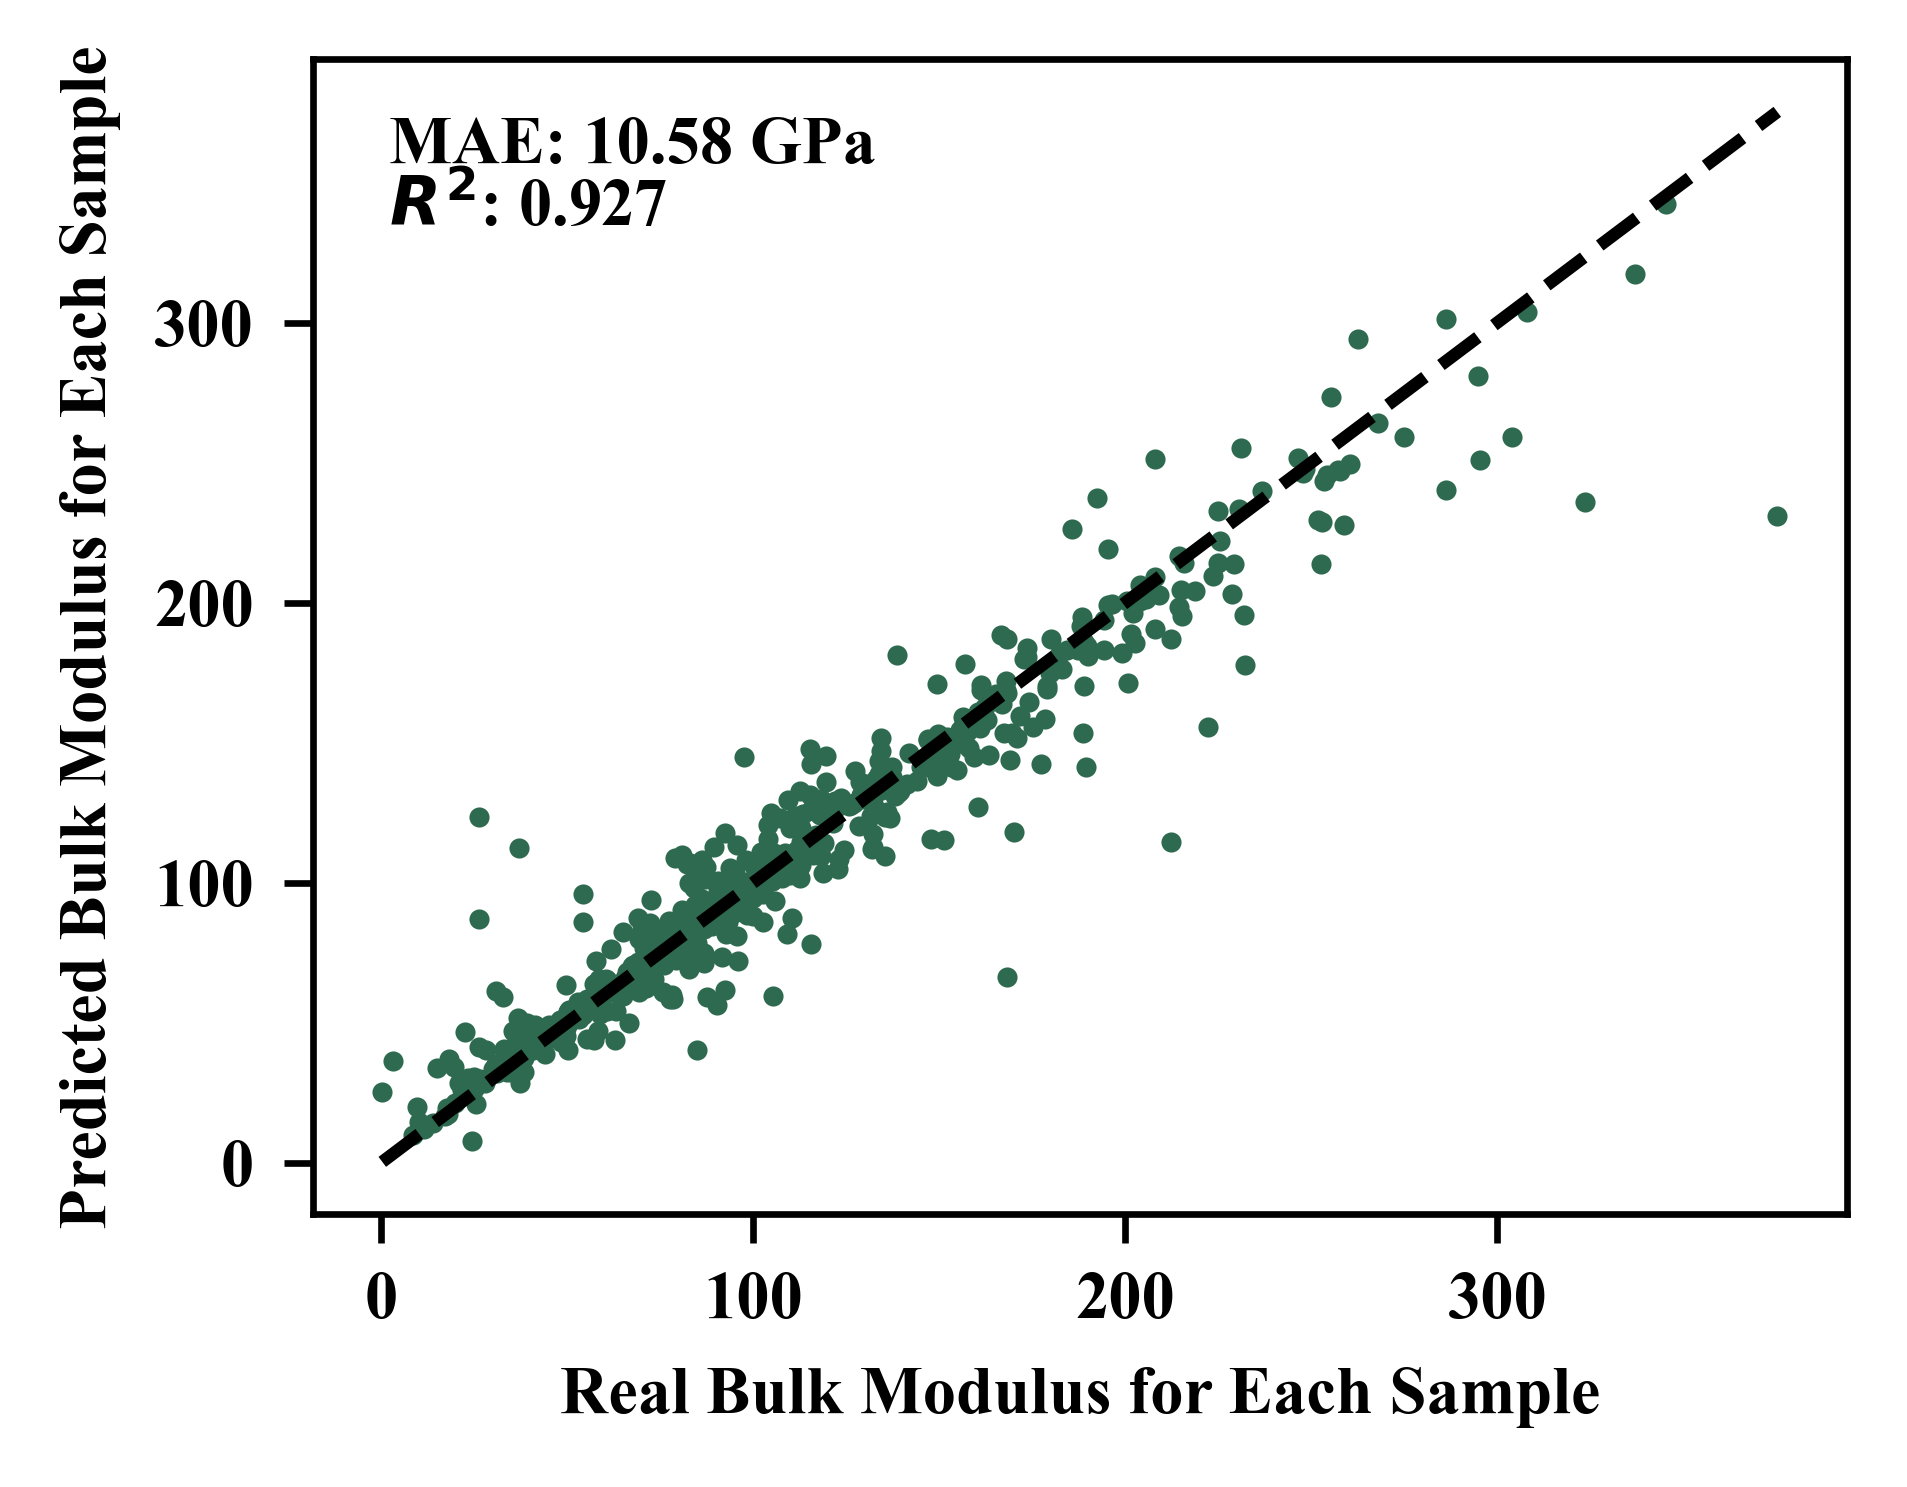

In [22]:
# rf_bulk
import matplotlib.pyplot as plt
plt.scatter(real_k_voigt, test_k_voigt, color='#2d6a4f', s=2)  # Adjusted point size
plt.xlabel('Real Bulk Modulus for Each Sample')
plt.ylabel('Predicted Bulk Modulus for Each Sample')
plt.plot([min(real_k_voigt), max(real_k_voigt)], [min(real_k_voigt), max(real_k_voigt)], 'k--')  # y=x dashed line in black
plt.text(0.05, 0.95, 'MAE: 10.58 GPa', transform=plt.gca().transAxes, fontsize=8, verticalalignment='top')
plt.text(0.05, 0.90, r'$R^2$: 0.927', transform=plt.gca().transAxes, fontsize=8, verticalalignment='top')
plt.savefig("rf_bulk_scatter.pdf", dpi=600, bbox_inches='tight')
plt.show()